# Mnist Drawing AI
## Version 1.0
Das Ziel dieser AI ist es einmal ein funktionierendes Environnment zu kreieren,
in der die KI lernen und arbeiten kann.

Hierbei soll wenigstens geschaut werden, ob die AI es erlernt mal nur ein Bild
zu zeichnen. In einer späteren Version sollen erst dann mehrere Bilder
hineingegeben werden.

Dabei soll als Input dienen:
- Ziel Bild 28x28 -> np.shape = (784,)
- States
    - Canvas State 28x28 -> np.shape = (784,)
    - Position von Agent in Space (Pen Position) -> np.shape(2,)

Dabei soll der Output sein:
- Integer
    - Es wird immer 1, 2, 3, 4 Gezählt, welches die Himmelsrichtungen darstellt.
    - Eine erhöhter Wert wird in den Stroke in die Länge gehen -> Bsp. 8 -> 2 Mal nach Links (Direction 4 und Length 2)

## Importing

In [1]:
import abc
import tensorflow as tf
import numpy as np
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils

import reverb

In [2]:
tf.config.list_physical_devices()

2022-04-20 17:54:40.430426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 17:54:40.451118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 17:54:40.451244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import matplotlib.pyplot as plt

In [4]:
from environnment import Canvas

## Env, Model and Agent Creation

### Load Dataset

In [5]:
from keras.datasets import mnist

In [6]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [7]:
env_py = Canvas(train_X[0])
env = tf_py_environment.TFPyEnvironment(env_py)

### Model

In [8]:
fc_layer_params = (100, 50) # Die Anzahl der Dense Units in einem Layer
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print("Num Actions: ", num_actions)

# Helper function um die Dense Layer zu kreeieren.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Create the dense layer array
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

# Create the output layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# Sequentialize the layers into a tensorflow model
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Num Actions:  4


### Agent

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-04-20 17:54:41.098487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 17:54:41.099508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 17:54:41.099711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 17:54:41.099826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Random Metrics

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    env_py.render("compare")
    return avg_return.numpy()[0]

/home/lars/GitHub/Nachzeichner-KI/experiments/mnistdrawing1_0/environnment.py:135: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


7.4400015

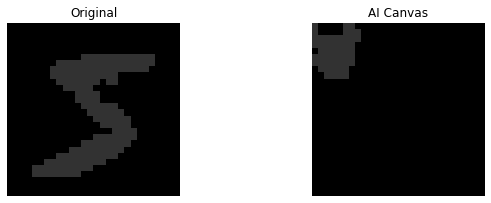

In [11]:
compute_avg_return(env,
                   random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                   env.action_spec()),
                   10)

## Replay Buffer

In [12]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=100000,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmpri62wvb2.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmpri62wvb2
[reverb/cc/platform/default/server.cc:71] Started replay server on port 15207


### Testing the replay buffer

In [13]:
py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                        env.action_spec()),
        use_tf_function=True),
        [rb_observer],
        max_steps=100
    ).run(env_py.reset())

(TimeStep(
 {'discount': array(0.5, dtype=float32),
  'observation': array([0, 0, 0, ..., 0, 0, 3], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [14]:
iter(replay_buffer.as_dataset()).next()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 1], dtype=int32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 1570), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 3],
        [0, 0, 0, ..., 0, 0, 2]], dtype=int32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([2153151324110437098, 2153151324110437098], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>))

In [15]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

In [16]:
iterator = iter(dataset)
print(iterator)

In [17]:
next(iterator)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (95316) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[2, 3],
        [0, 2],
        [1, 3],
        [2, 2],
        [1, 2],
        [3, 1],
        [0, 2],
        [2, 3],
        [1, 3],
        [3, 3],
        [3, 3],
        [1, 0],
        [3, 2],
        [3, 1],
        [3, 1],
        [2, 2],
        [3, 2],
        [2, 2],
        [3, 0],
        [1, 1],
        [3, 1],
        [3, 2],
        [0, 2],
        [3, 0],
        [2, 3],
        [1, 3],
        [2, 2],
        [1, 2],
        [2, 0],
        [2, 2],
        [2, 0],
        [0, 2],
        [1, 3],
        [2, 1],
        [3, 0],
        [1, 1],
        [2, 2],
        [3, 1],
        [2, 2],
        [3, 1],
        [1, 3],
        [3, 2],
        [3, 1],
        [2, 3],
        [1, 2],
        [3, 2],
        [0, 2],
        [2, 1],
        [2, 2],
        [2, 3],
        [2, 2],
        [2, 0],
        [3, 0],
        [2, 3],
        [3, 1],
        [0, 2],
        [1, 3],
        [3, 3],


## AI Training

In [18]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [19]:
time_step = env_py.reset()

In [20]:
# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=1)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 100: loss = 0.08713829517364502
step = 200: loss = 0.028033003211021423
step = 300: loss = 0.041163407266139984
step = 400: loss = 0.07821415364742279
step = 500: loss = 0.1426268219947815
step = 600: loss = 0.07397311925888062
step = 700: loss = 0.06341683864593506
step = 800: loss = 0.12683212757110596
step = 900: loss = 0.051376041024923325
step = 1000: loss = 0.09388060867786407
step = 1000: Average Return = -1.1000001430511475
step = 1100: loss = 0.03989802673459053
step = 1200: loss = 0.018574494868516922
step = 1300: loss = 0.035427533090114594
step = 1400: loss = 0.049628060311079025
step = 1500: loss = 0.038561247289180756
step = 1600: loss = 0.06829250603914261
step = 1700: loss = 0.02382984757423401
step = 1800: loss = 0.01418210752308368

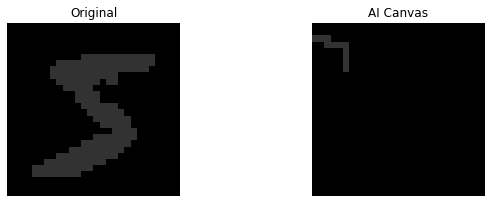

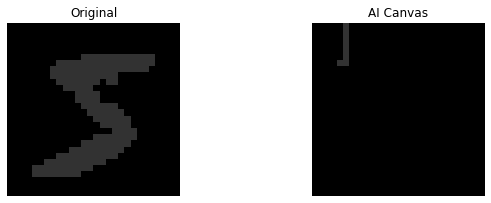

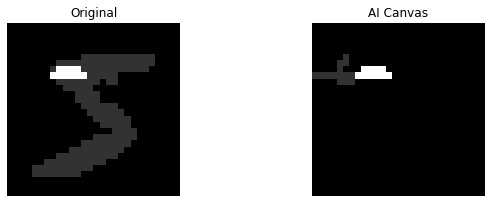

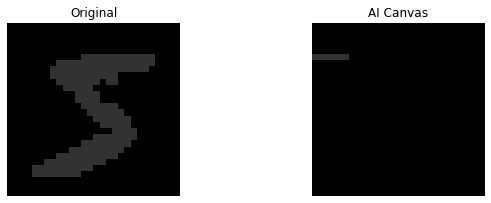

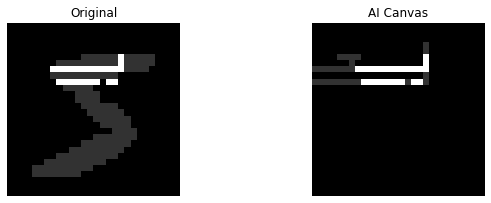

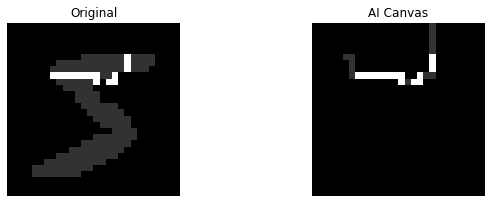

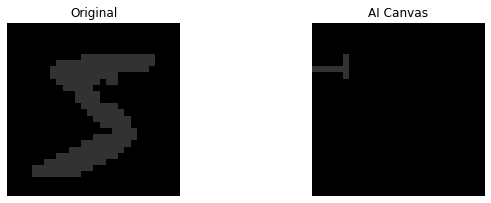

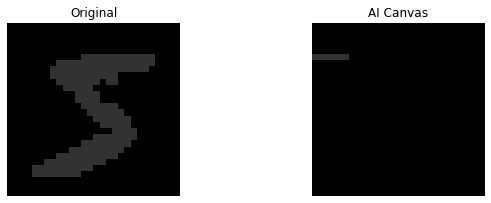

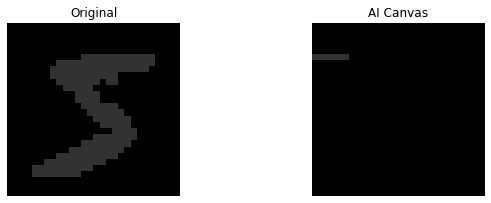

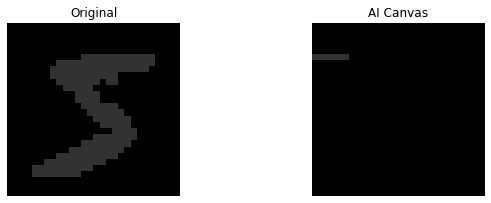

In [21]:
returns = []
for _ in range(10000):
    
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % 100 == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % 1000 == 0:
    avg_return = compute_avg_return(env, agent.policy, 1)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)